# TyBox (quantized FE) with CNAS baseline model: Incremental Learning scenario


This Notebook shows the use of the extended version of TyBox that implements full-integer quantization (https://github.com/pavmassimo/TyBox/tree/feature-extractor-quantization) on a CNAS-designed architecture (https://github.com/matteogambella/NAS) for the generation of an incremental solution able to address an incremental class learning scenario.

The CIFAR-10 dataset was used to prove the capabilities of the toolbox. Two classes in the dataset have been omitted from the initial training to simulate an incremental use case.

A full description of the experiment is provided in the Master Thesis executive summary present in the GitHub repository.

In [79]:
!pip install matplotlib

In [80]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from keras import layers
# from keras.utils import np_utils
from keras import backend as K 
K.set_image_data_format('channels_last')

from sklearn.preprocessing import OneHotEncoder

import sys
# insert at 1, 0 is the script path (or '' in REPL)
sys.path.append('.//TyBox')

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

from TyBox import TyBox
from TyBox import profiler

from matplotlib import pyplot as plt

Download and preparation of the dataset:

In [81]:
from keras.datasets import cifar10
# Load data 
(train_examples, train_labels), (test_examples, test_labels) = cifar10.load_data()

In [82]:
from keras.preprocessing.image import ImageDataGenerator

train_examples = train_examples.astype('float32')
test_examples = test_examples.astype('float32')

train_examples = train_examples / 255.0
test_examples = test_examples / 255.0

# # One hot encode target values
# train_labels = np_utils.to_categorical(train_labels)
# test_labels = np_utils.to_categorical(test_labels)

train_datagen = ImageDataGenerator(
    #   rotation_range=20,
      width_shift_range=0.1,
      height_shift_range=0.1,
    #   shear_range=0.2,
    #   zoom_range=0.2,
      horizontal_flip=True
    #   fill_mode='nearest'
)

# train_datagen.fit(train_examples)

# # Flow training images in batches of 96 using train_datagen generator
# train_generator = train_datagen.flow(train_examples, test_dataset, batch_size=96)

## Manually build the Keras model

In [83]:
inputs = tf.keras.Input(shape=(32, 32, 3))

### **First convolutional layer**

In [84]:
# (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
x = layers.Conv2D(filters=16, kernel_size=(3, 3), strides=(2, 2), padding='same', use_bias=False)(inputs)

# (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
x = layers.BatchNormalization(momentum=0.1, epsilon=1e-05)(x)

# (act): Hswish(): implemented with swish (possible solution: implement hard-swish as custom activation function)
x = layers.Activation('swish')(x)

### **Blocks**

#### **Block 0**

In [85]:
# (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
x = layers.Conv2D(filters=16, kernel_size=(3, 3), strides=(1, 1), padding='same', groups=16, use_bias=False)(x)

# (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
x = layers.BatchNormalization(momentum=0.1, epsilon=1e-05)(x)

# (act): ReLU(inplace=True)
# inplace=True means that it will modify the input directly, without allocating any additional output. It can sometimes slightly decrease the memory usage
x = layers.Activation('relu')(x)

In [86]:
# (conv): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
x = layers.Conv2D(filters=16, kernel_size=(1, 1), strides=(1, 1), padding='same', use_bias=False)(x)

# (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
x = layers.BatchNormalization(momentum=0.1, epsilon=1e-05)(x)

#### **Block 1**

In [87]:
# (conv): Conv2d(16, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
x = layers.Conv2D(filters=48, kernel_size=(1, 1), strides=(1, 1), padding='same', use_bias=False)(x)

# (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
x = layers.BatchNormalization(momentum=0.1, epsilon=1e-05)(x)

# (act): ReLU(inplace=True)
x = layers.Activation('relu')(x)

In [88]:
# (conv): Conv2d(48, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=48, bias=False)
x = layers.Conv2D(filters=48, kernel_size=(3, 3), strides=(2, 2), padding='same', groups=48, use_bias=False)(x)

# (bn): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
x = layers.BatchNormalization(momentum=0.1, epsilon=1e-05)(x)

# (act): ReLU(inplace=True)
x = layers.Activation('relu')(x)

In [89]:
# (act): Conv2d(48, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
x = layers.Conv2D(filters=24, kernel_size=(1, 1), strides=(1, 1), padding='same', use_bias=False)(x)

# (bn): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
x = layers.BatchNormalization(momentum=0.1, epsilon=1e-05)(x)

#### **Block 2**

In [90]:
# (conv): Conv2d(24, 72, kernel_size=(1, 1), stride=(1, 1), bias=False)
x = layers.Conv2D(filters=72, kernel_size=(1, 1), strides=(1, 1), padding='same', use_bias=False)(x)

# (bn): BatchNorm2d(72, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
x = layers.BatchNormalization(momentum=0.1, epsilon=1e-05)(x)

# (act): ReLU(inplace=True)
x = layers.Activation('relu')(x)

In [91]:
# (conv): Conv2d(72, 72, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=72, bias=False)
x = layers.Conv2D(filters=72, kernel_size=(3, 3), strides=(1, 1), padding='same', groups=72, use_bias=False)(x)

# (bn): BatchNorm2d(72, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
x = layers.BatchNormalization(momentum=0.1, epsilon=1e-05)(x)

# (act): ReLU(inplace=True)
x = layers.Activation('relu')(x)

In [92]:
# (conv): Conv2d(72, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
x = layers.Conv2D(filters=24, kernel_size=(1, 1), strides=(1, 1), padding='same', use_bias=False)(x)

# (bn): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
x = layers.BatchNormalization(momentum=0.1, epsilon=1e-05)(x)

#### **Block 3**

In [93]:
# (conv): Conv2d(24, 72, kernel_size=(1, 1), stride=(1, 1), bias=False)
x = layers.Conv2D(filters=72, kernel_size=(1, 1), strides=(1, 1), padding='same', use_bias=False)(x)

# (bn): BatchNorm2d(72, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
x = layers.BatchNormalization(momentum=0.1, epsilon=1e-05)(x)

# (act): ReLU(inplace=True)
x = layers.Activation('relu')(x)

In [94]:
# (conv): Conv2d(72, 72, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=72, bias=False)
x = layers.Conv2D(filters=72, kernel_size=(3, 3), strides=(2, 2), padding='same', groups=72, use_bias=False)(x)

# (bn): BatchNorm2d(72, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
x = layers.BatchNormalization(momentum=0.1, epsilon=1e-05)(x)

# (act): ReLU(inplace=True)
x = layers.Activation('relu')(x)

In [95]:
se1 = layers.GlobalAveragePooling2D(keepdims=True)(x)

# (reduce): Conv2d(72, 24, kernel_size=(1, 1), stride=(1, 1))
x = layers.Conv2D(filters=24, kernel_size=(1, 1), strides=(1, 1), padding='same')(se1)

# (relu): ReLU(inplace=True)
x = layers.Activation('relu')(x)

# (expand): Conv2d(24, 72, kernel_size=(1, 1), stride=(1, 1))
x = layers.Conv2D(filters=72, kernel_size=(1, 1), strides=(1, 1), padding='same')(x)

# (h_sigmoid): Hsigmoid()
x = layers.Activation('hard_sigmoid')(x)

x = layers.Multiply()([x, se1])
# x = tf.math.multiply(x, se1)

In [96]:
# (conv): Conv2d(72, 40, kernel_size=(1, 1), stride=(1, 1), bias=False)
x = layers.Conv2D(filters=40, kernel_size=(1, 1), strides=(1, 1), padding='same', use_bias=False)(x)

# (bn): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
x = layers.BatchNormalization(momentum=0.1, epsilon=1e-05)(x)

#### **Block 4**

In [97]:
# (conv): Conv2d(40, 120, kernel_size=(1, 1), stride=(1, 1), bias=False)
x = layers.Conv2D(filters=120, kernel_size=(1, 1), strides=(1, 1), padding='same', use_bias=False)(x)

# (bn): BatchNorm2d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
x = layers.BatchNormalization(momentum=0.1, epsilon=1e-05)(x)

# (act): ReLU(inplace=True)
x = layers.Activation('relu')(x)

In [98]:
# (conv): Conv2d(120, 120, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=120, bias=False)
x = layers.Conv2D(filters=120, kernel_size=(3, 3), strides=(1, 1), padding='same', groups=120, use_bias=False)(x)

# (bn): BatchNorm2d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
x = layers.BatchNormalization(momentum=0.1, epsilon=1e-05)(x)

# (act): ReLU(inplace=True)
x = layers.Activation('relu')(x)

In [99]:
se2 = layers.GlobalAveragePooling2D(keepdims=True)(x)

# (reduce): Conv2d(120, 32, kernel_size=(1, 1), stride=(1, 1))
x = layers.Conv2D(filters=32, kernel_size=(1, 1), strides=(1, 1), padding='same')(se2)

# (relu): ReLU(inplace=True)
x = layers.Activation('relu')(x)

# (expand): Conv2d(32, 120, kernel_size=(1, 1), stride=(1, 1))
x = layers.Conv2D(filters=120, kernel_size=(1, 1), strides=(1, 1), padding='same')(x)

# (h_sigmoid): Hsigmoid()
x = layers.Activation('hard_sigmoid')(x)

x = layers.Multiply()([x, se2])
# x = tf.math.multiply(x, se2)

In [100]:
# (conv): Conv2d(120, 40, kernel_size=(1, 1), stride=(1, 1), bias=False)
x = layers.Conv2D(filters=40, kernel_size=(1, 1), strides=(1, 1), padding='same', use_bias=False)(x)

# (bn): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
x = layers.BatchNormalization(momentum=0.1, epsilon=1e-05)(x)

#### **Block 5**

In [101]:
# (conv): Conv2d(40, 120, kernel_size=(1, 1), stride=(1, 1), bias=False)
x = layers.Conv2D(filters=120, kernel_size=(1, 1), strides=(1, 1), padding='same', use_bias=False)(x)

# (bn): BatchNorm2d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
x = layers.BatchNormalization(momentum=0.1, epsilon=1e-05)(x)

# (act): Hswish()
x = layers.Activation('swish')(x)

In [102]:
# (conv): Conv2d(120, 120, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=120, bias=False)
x = layers.Conv2D(filters=120, kernel_size=(3, 3), strides=(2, 2), padding='same', groups=120, use_bias=False)(x)

# (bn): BatchNorm2d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
x = layers.BatchNormalization(momentum=0.1, epsilon=1e-05)(x)

# (act): Hswish()
x = layers.Activation('swish')(x)

In [103]:
# (conv): Conv2d(120, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
x = layers.Conv2D(filters=80, kernel_size=(1, 1), strides=(1, 1), padding='same', use_bias=False)(x)

# (bn): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
x = layers.BatchNormalization(momentum=0.1, epsilon=1e-05)(x)

#### **Block 6**

In [104]:
# (conv): Conv2d(80, 240, kernel_size=(1, 1), stride=(1, 1), bias=False)
x = layers.Conv2D(filters=240, kernel_size=(1, 1), strides=(1, 1), padding='same', use_bias=False)(x)

# (bn): BatchNorm2d(240, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
x = layers.BatchNormalization(momentum=0.1, epsilon=1e-05)(x)

# (act): Hswish()
x = layers.Activation('swish')(x)

In [105]:
# (conv): Conv2d(240, 240, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=240, bias=False)
x = layers.Conv2D(filters=240, kernel_size=(3, 3), strides=(1, 1), padding='same', groups=240, use_bias=False)(x)

# (bn): BatchNorm2d(240, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
x = layers.BatchNormalization(momentum=0.1, epsilon=1e-05)(x)

# (act): Hswish()
x = layers.Activation('swish')(x)

In [106]:
# (conv): Conv2d(240, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
x = layers.Conv2D(filters=80, kernel_size=(1, 1), strides=(1, 1), padding='same', use_bias=False)(x)

# (bn): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
x = layers.BatchNormalization(momentum=0.1, epsilon=1e-05)(x)

#### **Block 7**

In [107]:
# (conv): Conv2d(80, 240, kernel_size=(1, 1), stride=(1, 1), bias=False)
x = layers.Conv2D(filters=240, kernel_size=(1, 1), strides=(1, 1), padding='same', use_bias=False)(x)

# (bn): BatchNorm2d(240, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
x = layers.BatchNormalization(momentum=0.1, epsilon=1e-05)(x)

# (act): Hswish()
x = layers.Activation('swish')(x)

In [108]:
# (conv): Conv2d(240, 240, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=240, bias=False)
x = layers.Conv2D(filters=240, kernel_size=(3, 3), strides=(1, 1), padding='same', groups=240, use_bias=False)(x)

# (bn): BatchNorm2d(240, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
x = layers.BatchNormalization(momentum=0.1, epsilon=1e-05)(x)

# (act): Hswish()
x = layers.Activation('swish')(x)

In [109]:
se3 = layers.GlobalAveragePooling2D(keepdims=True)(x)

# (reduce): Conv2d(240, 64, kernel_size=(1, 1), stride=(1, 1))
x = layers.Conv2D(filters=64, kernel_size=(1, 1), strides=(1, 1), padding='same')(se3)

# (relu): ReLU(inplace=True)
x = layers.Activation('relu')(x)

# (expand): Conv2d(64, 240, kernel_size=(1, 1), stride=(1, 1))
x = layers.Conv2D(filters=240, kernel_size=(1, 1), strides=(1, 1), padding='same')(x)

# (h_sigmoid): Hsigmoid()
x = layers.Activation('hard_sigmoid')(x)

x = layers.Multiply()([x, se3])
# x = tf.math.multiply(x, se3)

In [110]:
# (conv): Conv2d(240, 112, kernel_size=(1, 1), stride=(1, 1), bias=False)
x = layers.Conv2D(filters=112, kernel_size=(1, 1), strides=(1, 1), padding='same', use_bias=False)(x)

# (bn): BatchNorm2d(112, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
x = layers.BatchNormalization(momentum=0.1, epsilon=1e-05)(x)

#### **Block 8**

In [111]:
# (conv): Conv2d(112, 336, kernel_size=(1, 1), stride=(1, 1), bias=False)
x = layers.Conv2D(filters=336, kernel_size=(1, 1), strides=(1, 1), padding='same', use_bias=False)(x)

# (bn): BatchNorm2d(336, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
x = layers.BatchNormalization(momentum=0.1, epsilon=1e-05)(x)

# (act): Hswish()
x = layers.Activation('swish')(x)

In [112]:
# (conv): Conv2d(336, 336, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=336, bias=False)
x = layers.Conv2D(filters=336, kernel_size=(3, 3), strides=(1, 1), padding='same', groups=336, use_bias=False)(x)

# (bn): BatchNorm2d(336, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
x = layers.BatchNormalization(momentum=0.1, epsilon=1e-05)(x)

# (act): Hswish()
x = layers.Activation('swish')(x)

In [113]:
se4 = layers.GlobalAveragePooling2D(keepdims=True)(x)

# (reduce): Conv2d(336, 88, kernel_size=(1, 1), stride=(1, 1))
x = layers.Conv2D(filters=88, kernel_size=(1, 1), strides=(1, 1), padding='same')(se4)

# (relu): ReLU(inplace=True)
x = layers.Activation('relu')(x)

# (expand): Conv2d(88, 336, kernel_size=(1, 1), stride=(1, 1))
x = layers.Conv2D(filters=336, kernel_size=(1, 1), strides=(1, 1), padding='same')(x)

# (h_sigmoid): Hsigmoid()
x = layers.Activation('hard_sigmoid')(x)

x = layers.Multiply()([x, se4])
# x = tf.math.multiply(x, se4)

In [114]:
# (conv): Conv2d(336, 112, kernel_size=(1, 1), stride=(1, 1), bias=False)
x = layers.Conv2D(filters=112, kernel_size=(1, 1), strides=(1, 1), padding='same', use_bias=False)(x)

# (bn): BatchNorm2d(112, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
x = layers.BatchNormalization(momentum=0.1, epsilon=1e-05)(x)

#### **Block 9**

In [115]:
# (conv): Conv2d(112, 336, kernel_size=(1, 1), stride=(1, 1), bias=False)
x = layers.Conv2D(filters=336, kernel_size=(1, 1), strides=(1, 1), padding='same', use_bias=False)(x)

# (bn): BatchNorm2d(336, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
x = layers.BatchNormalization(momentum=0.1, epsilon=1e-05)(x)

# (act): Hswish()
x = layers.Activation('swish')(x)

In [116]:
# (conv): Conv2d(336, 336, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=336, bias=False)
x = layers.Conv2D(filters=336, kernel_size=(3, 3), strides=(2, 2), padding='same', groups=336, use_bias=False)(x)

# (bn): BatchNorm2d(336, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
x = layers.BatchNormalization(momentum=0.1, epsilon=1e-05)(x)

# (act): Hswish()
x = layers.Activation('swish')(x)

In [117]:
se5 = layers.GlobalAveragePooling2D(keepdims=True)(x)

# (reduce): Conv2d(336, 88, kernel_size=(1, 1), stride=(1, 1))
x = layers.Conv2D(filters=88, kernel_size=(1, 1), strides=(1, 1), padding='same')(se5)

# (relu): ReLU(inplace=True)
x = layers.Activation('relu')(x)

# (expand): Conv2d(88, 336, kernel_size=(1, 1), stride=(1, 1))
x = layers.Conv2D(filters=336, kernel_size=(1, 1), strides=(1, 1), padding='same')(x)

# (h_sigmoid): Hsigmoid()
x = layers.Activation('hard_sigmoid')(x)

x = layers.Multiply()([x, se5])
# x = tf.math.multiply(x, se5)

In [118]:
# (conv): Conv2d(336, 160, kernel_size=(1, 1), stride=(1, 1), bias=False)
x = layers.Conv2D(filters=160, kernel_size=(1, 1), strides=(1, 1), padding='same', use_bias=False)(x)

# (bn): BatchNorm2d(160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
x = layers.BatchNormalization(momentum=0.1, epsilon=1e-05)(x)

#### **Block 10**

In [119]:
# (conv): Conv2d(160, 480, kernel_size=(1, 1), stride=(1, 1), bias=False)
x = layers.Conv2D(filters=480, kernel_size=(1, 1), strides=(1, 1), padding='same', use_bias=False)(x)

# (bn): BatchNorm2d(480, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
x = layers.BatchNormalization(momentum=0.1, epsilon=1e-05)(x)

# (act): Hswish()
x = layers.Activation('swish')(x)

In [120]:
# (conv): Conv2d(480, 480, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=480, bias=False)
x = layers.Conv2D(filters=480, kernel_size=(3, 3), strides=(1, 1), padding='same', groups=480, use_bias=False)(x)

# (bn): BatchNorm2d(480, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
x = layers.BatchNormalization(momentum=0.1, epsilon=1e-05)(x)

# (act): Hswish()
x = layers.Activation('swish')(x)

In [121]:
se6 = layers.GlobalAveragePooling2D(keepdims=True)(x)

# (reduce): Conv2d(480, 120, kernel_size=(1, 1), stride=(1, 1))
x = layers.Conv2D(filters=120, kernel_size=(1, 1), strides=(1, 1), padding='same')(se6)

# (relu): ReLU(inplace=True)
x = layers.Activation('relu')(x)

# (expand): Conv2d(120, 480, kernel_size=(1, 1), stride=(1, 1))
x = layers.Conv2D(filters=480, kernel_size=(1, 1), strides=(1, 1), padding='same')(x)

# (h_sigmoid): Hsigmoid()
x = layers.Activation('hard_sigmoid')(x)

x = layers.Multiply()([x, se6])
# x = tf.math.multiply(x, se6)

In [122]:
# (conv): Conv2d(480, 160, kernel_size=(1, 1), stride=(1, 1), bias=False)
x = layers.Conv2D(filters=160, kernel_size=(1, 1), strides=(1, 1), padding='same', use_bias=False)(x)

# (bn): BatchNorm2d(160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
x = layers.BatchNormalization(momentum=0.1, epsilon=1e-05)(x)

### **Final expand layer**

In [123]:
# (conv): Conv2d(160, 960, kernel_size=(1, 1), stride=(1, 1), bias=False)
x = layers.Conv2D(filters=960, kernel_size=(1, 1), strides=(1, 1), padding='same', use_bias=False)(x)

# (bn): BatchNorm2d(960, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
x = layers.BatchNormalization(momentum=0.1, epsilon=1e-05)(x)

# (act): Hswish()
x = layers.Activation('swish')(x)

### **Global average pooling** 
**(from forward function in mobilenet_v3.py)**

In [124]:
# x = x.mean(3, keepdim=True).mean(2, keepdim=True)
x = layers.GlobalAveragePooling2D(keepdims=True)(x)

### **Feature mix layer**

In [125]:
# (conv): Conv2d(960, 1280, kernel_size=(1, 1), stride=(1, 1), bias=False)
x = layers.Conv2D(filters=1280, kernel_size=(1, 1), strides=(1, 1), use_bias=False)(x)

# (act): Hswish()
x = layers.Activation('swish')(x)

### **Squeeze**

In [126]:
# x = torch.squeeze(x)
x = layers.Flatten()(x)

### **Classifier**

In [127]:
# (dropout): Dropout(p=0.2, inplace=True)
x = layers.Dropout(rate=0.2)(x)
# (linear): Linear(in_features=1280, out_features=10, bias=True)
outputs = layers.Dense(units=10, activation='softmax', 
                            kernel_regularizer=tf.keras.regularizers.L2(l2=0.025),
                            bias_regularizer=tf.keras.regularizers.L2(l2=0.01)
                            # activity_regularizer=tf.keras.regularizers.L2(l2=0.001)
                            )(x)

### Model summary

In [128]:
model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [129]:
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv2d_47 (Conv2D)          (None, 16, 16, 16)           432       ['input_8[0][0]']             
                                                                                                  
 batch_normalization_34 (Ba  (None, 16, 16, 16)           64        ['conv2d_47[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_36 (Activation)  (None, 16, 16, 16)           0         ['batch_normalization_34

### Model compile

In [130]:
# Compile model
lrate = 0.00125
adam = tf.keras.optimizers.Adam(learning_rate=lrate)

model.compile(loss=keras.losses.CategoricalCrossentropy(), optimizer=adam, metrics=['accuracy'])

In [131]:
layer_w = model.layers[-1].get_weights()[0]
weights = []

for elem in layer_w:
  weights.append(elem[8:10])

biases = np.array(model.layers[-1].get_weights()[1])

weights = np.array(weights)
print(weights)

[[ 0.03299477 -0.03215409]
 [ 0.02776104 -0.02710531]
 [ 0.02030624 -0.0574109 ]
 ...
 [-0.05104286 -0.02827857]
 [-0.03747767  0.00484829]
 [ 0.0319139   0.06747889]]


## Network Profiler
It is possible now to initialize the profiler with the defined model.
The profiler can provide useful information to the designer of the network on the memory occupations in terms of weights and activations, in total and at a per-layer granularity. 

In [132]:
# profiler = profiler.Profiler("model", model)
profiler = profiler.Profiler(network_name="model", model=model, precisions=[[32, 32], [32, 32]])

<class 'keras.src.engine.input_layer.InputLayer'>
evaluating <keras.src.engine.input_layer.InputLayer object at 0x000001D15C605FC0>
create_l
<class 'keras.src.engine.input_layer.InputLayer'>
[evaluate_layer()] layer:  input_8 InputLayer  is not supported
InputLayer
<class 'keras.src.layers.convolutional.conv2d.Conv2D'>
evaluating <keras.src.layers.convolutional.conv2d.Conv2D object at 0x000001D1B3C08C70>
create_l
<class 'keras.src.layers.convolutional.conv2d.Conv2D'>
Conv2D
<class 'keras.src.layers.normalization.batch_normalization.BatchNormalization'>
evaluating <keras.src.layers.normalization.batch_normalization.BatchNormalization object at 0x000001D1B3C08E50>
create_l
<class 'keras.src.layers.normalization.batch_normalization.BatchNormalization'>
[evaluate_layer()] layer:  batch_normalization_34 BatchNormalization  is not supported
BatchNormalization
<class 'keras.src.layers.core.activation.Activation'>
evaluating <keras.src.layers.core.activation.Activation object at 0x000001D15CD5

In [133]:
profiler.print_occupations()

total parameters fe:  2141728
total parameters classification head: 12810
total parameters:  2154538
peak activations fe: 24576
peak activations classification head: 2570
peak activations total: 27146
total parameters fe mem:  8566912.0 B
total parameters classification head mem: 51240.0 B
total parameters mem: 8618152.0 B
peak activations fe mem: 98304.0 B
peak activations classification head mem: 10280.0 B
peak activations total mem: 108584.0 B


In [134]:
profiler.print_per_layer()

InputLayer
memory = {'param': 0, 'act': 1}
operations = {'flops': None, 'maccs': None, 'divisions': None, 'sums': None, 'comparisons': None}
Conv2D
memory = {'param': 432, 'act': 4096}
operations = {'flops': 219108.0, 'maccs': 115320.0, 'divisions': 0, 'sums': 0, 'comparisons': 0}
BatchNormalization
memory = {'param': 64, 'act': 4096}
operations = {'flops': None, 'maccs': None, 'divisions': None, 'sums': None, 'comparisons': None}
swish
memory = {'param': 0, 'act': 4096}
operations = {'flops': None, 'maccs': None, 'divisions': None, 'sums': None, 'comparisons': None}
Conv2D
memory = {'param': 144, 'act': 4096}
operations = {'flops': 351232.0, 'maccs': 31360.0, 'divisions': 0, 'sums': 0, 'comparisons': 0}
BatchNormalization
memory = {'param': 64, 'act': 4096}
operations = {'flops': None, 'maccs': None, 'divisions': None, 'sums': None, 'comparisons': None}
relu
memory = {'param': 0, 'act': 4096}
operations = {'flops': 0, 'maccs': 0, 'divisions': 0, 'sums': 0, 'comparisons': 4096}
Conv2D


## Train the base network

We use the complete train dataset to train the base neural network on the task of recognizing the first 7 digits.

In [135]:
categorical_cifar_labels = np.zeros((50000, 10))
for i in range(len(train_labels)):
    categorical_cifar_labels[i][train_labels[i]] = 1

train_labels = categorical_cifar_labels
train_labels.shape

(50000, 10)

In [136]:
categorical_test_labels = np.zeros(shape=(10000, 10))
for i in range(len(test_labels)):
    categorical_test_labels[i][test_labels[i]] = 1

test_labels = categorical_test_labels
test_labels.shape

(10000, 10)

In [137]:
incremental_examples = np.empty((10000, 32, 32, 3))
start_examples = np.empty((10000, 32, 32, 3))
incremental_labels = np.empty((10000,10), dtype=np.uint8)
start_labels = np.empty((10000,10), dtype=np.uint8)
index_incremental = 0
index_start = 0

# Ship (8) and truck (9) are temporarily excluded by the dataset
for i in range(len(train_examples)):
    if np.argmax(train_labels[i]) > 7:
        if index_incremental >= 10000:
            continue
        incremental_examples[index_incremental] = train_examples[i]
        incremental_labels[index_incremental] = train_labels[i]
        index_incremental += 1
    else:
        if index_start >= 10000:
            continue
        start_examples[index_start] = train_examples[i]
        start_labels[index_start] = train_labels[i]
        index_start += 1
        
incremental_examples_test = np.empty((2000, 32, 32, 3))
start_examples_test = np.empty((2000, 32, 32, 3))
incremental_labels_test = np.empty((2000,10), dtype=np.uint8)
start_labels_test = np.empty((2000,10), dtype=np.uint8)
index_incremental = 0
index_start = 0

for i in range(len(test_examples)):
    if np.argmax(test_labels[i]) > 7:
        if index_incremental >= 2000:
            continue
        incremental_examples_test[index_incremental] = test_examples[i]
        incremental_labels_test[index_incremental] = test_labels[i]
        index_incremental += 1
    else:
        if index_start >= 2000:
            continue
        start_examples_test[index_start] = test_examples[i]
        start_labels_test[index_start] = test_labels[i]
        index_start += 1

In [138]:
layer_2 = model.layers[-1].get_weights()
layer_2_w = layer_2[0]

for i in range(len(layer_2_w)):
  layer_2_w[i][8] = weights[i][0]
  layer_2_w[i][9] = weights[i][1]

layer_2[0] = layer_2_w

layer_2[1][8] = biases[0]
layer_2[1][9] = biases[1]

model.layers[-1].set_weights(layer_2)
print(model.layers[-1].get_weights())

[array([[ 0.04792579,  0.01090091, -0.04164089, ..., -0.03497699,
         0.03299477, -0.03215409],
       [ 0.05793328,  0.06256568,  0.02830332, ..., -0.02418153,
         0.02776104, -0.02710531],
       [-0.04459336, -0.02446407, -0.00315499, ...,  0.06070178,
         0.02030624, -0.0574109 ],
       ...,
       [ 0.00263572, -0.01838082,  0.06571233, ..., -0.03376715,
        -0.05104286, -0.02827857],
       [ 0.01945487, -0.05107992,  0.06327292, ...,  0.00948893,
        -0.03747767,  0.00484829],
       [ 0.00465513,  0.04911245,  0.00386907, ..., -0.05325608,
         0.0319139 ,  0.06747889]], dtype=float32), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)]


In [139]:
#load the model weights
# model.load_weights('/kaggle/input/bestcheckpoint/model_trained')
model.load_weights('D:\Download\IncLearn_resultReplication_modelWeights\model_trained')

In [140]:
print(model.layers[-1].get_weights())

[array([[-2.7071164e-04,  3.3427679e-03, -1.9840416e-02, ...,
        -1.3084427e-02, -4.8591226e-02, -5.5387389e-02],
       [-9.6457778e-03,  1.7530527e-02,  6.5406720e-04, ...,
        -5.3190333e-03, -6.4073958e-02, -3.9005592e-02],
       [-3.6744026e-03,  8.3088884e-03, -6.5619489e-03, ...,
        -5.4871038e-05,  4.5818157e-02, -3.4003109e-03],
       ...,
       [ 5.1541976e-04,  4.5686375e-04, -7.0258284e-05, ...,
        -1.9618149e-03, -5.4141842e-02,  3.8908839e-02],
       [ 3.1113758e-04, -1.9533685e-03, -5.5892277e-04, ...,
        -1.5097640e-03, -1.1578608e-02, -2.3571294e-02],
       [ 1.0522282e-03, -1.2351618e-03,  3.1839882e-03, ...,
        -6.4982427e-04,  4.5358069e-02, -5.4212440e-02]], dtype=float32), array([ 0.00490642, -0.0004247 ,  0.02217042,  0.06798103,  0.01887804,
       -0.01817109,  0.00151054,  0.01536017,  0.        ,  0.        ],
      dtype=float32)]


In [141]:
# model.load_weights('model_trained')
start_examples_scores = model.evaluate(start_examples_test, start_labels_test)
incremental_examples_scores = model.evaluate(incremental_examples_test, incremental_labels_test)
test_scores = model.evaluate(test_examples, test_labels)
print(start_examples_scores, incremental_examples_scores, test_scores)

313/313 [==============================] - 38s 117ms/step - loss: 2.3827 - accuracy: 0.5195
[1.104305386543274, 0.6445000171661377] [7.481473922729492, 0.0] [2.3826584815979004, 0.5195000171661377]


## Python Incremental solution

To generate the python version of the incremental solution, it's sufficient to call 

*Tybox.create_python_learning_solution(tf_model, mem_available, precision)*

where mem_available is the amount of memory that can be dedicated to the machine learning on device (in Bytes), and precision is data precision of model and activations in bit (currently TyBox support only 32-bit floating point precision).


In [142]:
Mf_lite, Mc_python = TyBox.create_python_learning_solution(model, 9479965, 32)

# # Create a compressible model for TFLite using integer-only quantization
# def representative_data_gen():
#     for input_value in tf.data.Dataset.from_tensor_slices(train_examples).batch(1).take(500):
#         yield [input_value]
# yield_representative_dataset = representative_data_gen
# Mf_lite, Mc_python = TyBox.create_python_learning_solution(model, 2416132, 8, yield_representative_dataset)

1/1 [==============================] - 0s 77ms/step
INFO:tensorflow:Assets written to: C:\Users\mlaca\AppData\Local\Temp\tmpq9xy3v46\assets


INFO:tensorflow:Assets written to: C:\Users\mlaca\AppData\Local\Temp\tmpq9xy3v46\assets


<class 'keras.src.engine.input_layer.InputLayer'>
evaluating <keras.src.engine.input_layer.InputLayer object at 0x000001D15C605FC0>
create_l
<class 'keras.src.engine.input_layer.InputLayer'>
[evaluate_layer()] layer:  input_8 InputLayer  is not supported
InputLayer
<class 'keras.src.layers.convolutional.conv2d.Conv2D'>
evaluating <keras.src.layers.convolutional.conv2d.Conv2D object at 0x000001D1B3C08C70>
create_l
<class 'keras.src.layers.convolutional.conv2d.Conv2D'>
Conv2D
<class 'keras.src.layers.normalization.batch_normalization.BatchNormalization'>
evaluating <keras.src.layers.normalization.batch_normalization.BatchNormalization object at 0x000001D1B3C08E50>
create_l
<class 'keras.src.layers.normalization.batch_normalization.BatchNormalization'>
[evaluate_layer()] layer:  batch_normalization_34 BatchNormalization  is not supported
BatchNormalization
<class 'keras.src.layers.core.activation.Activation'>
evaluating <keras.src.layers.core.activation.Activation object at 0x000001D15CD5

In [143]:
with open("mf.tflite", "wb") as file:
    file.write(Mf_lite)

#tf-lite model preparation
interpreter = tf.lite.Interpreter('mf.tflite')
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()[0]
print(input_details)
output_details = interpreter.get_output_details()[0]
print(output_details)

#feature extraction with the tf-lite model
extracted_features = []
for i in range(len(train_labels)):
    input_data = train_examples[i].reshape((1, 32, 32, 3))
    
    if input_details['dtype'] == np.uint8:
        input_scale, input_zero_point = input_details["quantization"]
        input_data = input_data / input_scale + input_zero_point
    
    input_data = input_data.astype(input_details["dtype"])
    # print(input_data)
    interpreter.set_tensor(input_details["index"], input_data)
    interpreter.invoke()
    output = interpreter.get_tensor(output_details["index"])[0]
    # print(output)

    extracted_features.append(interpreter.get_tensor(output_details['index']))
extracted_features = np.array(extracted_features)[:,0,:]
# print(test_feature.shape, test_feature.dtype)

{'name': 'serving_default_input_9:0', 'index': 0, 'shape': array([ 1, 32, 32,  3]), 'shape_signature': array([-1, 32, 32,  3]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}
{'name': 'StatefulPartitionedCall:0', 'index': 194, 'shape': array([   1, 1280]), 'shape_signature': array([  -1, 1280]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}


In [144]:
extracted_features_test = []
for i in range(len(test_labels)):
    input_data = test_examples[i].reshape((1, 32, 32, 3))
    
    if input_details['dtype'] == np.uint8:
        input_scale, input_zero_point = input_details["quantization"]
        input_data = input_data / input_scale + input_zero_point
    
    input_data = input_data.astype(input_details["dtype"])
    # print(input_data)
    interpreter.set_tensor(input_details["index"], input_data)
    interpreter.invoke()
    output = interpreter.get_tensor(output_details["index"])[0]
    # print(output)

    extracted_features_test.append(interpreter.get_tensor(output_details['index']))
extracted_features_test = np.array(extracted_features_test)[:,0,:]
# print(test_feature.shape, test_feature.dtype)

In [145]:
extracted_start_features_test = []
for i in range(len(start_labels_test)):
    input_data = start_examples_test[i].reshape((1, 32, 32, 3))
    
    if input_details['dtype'] == np.uint8:
        input_scale, input_zero_point = input_details["quantization"]
        input_data = input_data / input_scale + input_zero_point
    
    input_data = input_data.astype(input_details["dtype"])
    # print(input_data)
    interpreter.set_tensor(input_details["index"], input_data)
    interpreter.invoke()
    output = interpreter.get_tensor(output_details["index"])[0]
    # print(output)

    extracted_start_features_test.append(interpreter.get_tensor(output_details['index']))
extracted_start_features_test = np.array(extracted_start_features_test)[:,0,:]
# print(test_feature.shape, test_feature.dtype)

In [146]:
extracted_start_features = []
for i in range(len(start_labels)):
    input_data = start_examples[i].reshape((1, 32, 32, 3))
    
    if input_details['dtype'] == np.uint8:
        input_scale, input_zero_point = input_details["quantization"]
        input_data = input_data / input_scale + input_zero_point
    
    input_data = input_data.astype(input_details["dtype"])
    # print(input_data)
    interpreter.set_tensor(input_details["index"], input_data)
    interpreter.invoke()
    output = interpreter.get_tensor(output_details["index"])[0]
    # print(output)

    extracted_start_features.append(interpreter.get_tensor(output_details['index']))
extracted_start_features = np.array(extracted_start_features)[:,0,:]
# print(test_feature.shape, test_feature.dtype)

In [147]:
extracted_incremental_features = []
for i in range(len(incremental_labels)):
    input_data = incremental_examples[i].reshape((1, 32, 32, 3))
    
    if input_details['dtype'] == np.uint8:
        input_scale, input_zero_point = input_details["quantization"]
        input_data = input_data / input_scale + input_zero_point
    
    input_data = input_data.astype(input_details["dtype"])
    # print(input_data)
    interpreter.set_tensor(input_details["index"], input_data)
    interpreter.invoke()
    output = interpreter.get_tensor(output_details["index"])[0]
    # print(output)

    extracted_incremental_features.append(interpreter.get_tensor(output_details['index']))
extracted_incremental_features = np.array(extracted_incremental_features)[:,0,:]
# print(test_feature.shape, test_feature.dtype)

In [148]:
extracted_incremental_features_test = []
for i in range(len(incremental_labels_test)):
    input_data = incremental_examples_test[i].reshape((1, 32, 32, 3))
    
    if input_details['dtype'] == np.uint8:
        input_scale, input_zero_point = input_details["quantization"]
        input_data = input_data / input_scale + input_zero_point
    
    input_data = input_data.astype(input_details["dtype"])
    # print(input_data)
    interpreter.set_tensor(input_details["index"], input_data)
    interpreter.invoke()
    output = interpreter.get_tensor(output_details["index"])[0]
    # print(output)

    extracted_incremental_features_test.append(interpreter.get_tensor(output_details['index']))
extracted_incremental_features_test = np.array(extracted_incremental_features_test)[:,0,:]
# print(test_feature.shape, test_feature.dtype)

### TyBox: python model usage

In [149]:
import random

#n of times the experiment will be repeated.
n_repetitions = 5

#n of data used in the experiment
exp_l = 700

#time of the introduction of the new classes
new_subject_time = 50

accuracies_tb = []

for repetition in range(n_repetitions):
    res_acc_old_tb = []
    res_acc_new_tb = []

    #load the original model and convert it
#     model.load_weights('model_trained')
    fe_model, python_model = TyBox.create_python_learning_solution(model, 9479965, 32)
#     def representative_data_gen():
#         for input_value in tf.data.Dataset.from_tensor_slices(train_examples).batch(1).take(500):
#             yield [input_value]
#     yield_representative_dataset = representative_data_gen
#     fe_model, python_model = TyBox.create_python_learning_solution(model, 2416132, 8, yield_representative_dataset)
    python_model.set_lr(0.00025)

    #fix seed for reproducibility
    random.seed(42 + repetition)

    indices = random.sample(range(len(extracted_features)), exp_l)
    indices_2 = random.sample(range(len(extracted_start_features)), exp_l)
    
    step = 0

    for i in indices:

        if step < new_subject_time:
            sample = indices_2[step]
            sample_data = extracted_start_features[sample]
            sample_label = start_labels[sample]
        
        else:
            sample = i
            sample_data = extracted_features[sample]
            sample_label = train_labels[sample]
        
        #push datum into buffer and train on the whole buffer
        python_model.push_and_train(sample_data, sample_label)

        #evaluate accuracies on test sets

        accuracy_old = python_model.evaluate(extracted_start_features_test[:200], start_labels_test[:200], output_details["quantization"])
        accuracy_new = python_model.evaluate(extracted_incremental_features_test[:200], incremental_labels_test[:200], output_details["quantization"])
        
        res_acc_old_tb.append(accuracy_old)
        res_acc_new_tb.append(accuracy_new)

        
        print(step, accuracy_new, accuracy_old)
        step += 1
    accuracies_tb.append((res_acc_old_tb, res_acc_new_tb))

1/1 [==============================] - 0s 87ms/step
INFO:tensorflow:Assets written to: C:\Users\mlaca\AppData\Local\Temp\tmpcp7toi21\assets


INFO:tensorflow:Assets written to: C:\Users\mlaca\AppData\Local\Temp\tmpcp7toi21\assets


<class 'keras.src.engine.input_layer.InputLayer'>
evaluating <keras.src.engine.input_layer.InputLayer object at 0x000001D15C605FC0>
create_l
<class 'keras.src.engine.input_layer.InputLayer'>
[evaluate_layer()] layer:  input_8 InputLayer  is not supported
InputLayer
<class 'keras.src.layers.convolutional.conv2d.Conv2D'>
evaluating <keras.src.layers.convolutional.conv2d.Conv2D object at 0x000001D1B3C08C70>
create_l
<class 'keras.src.layers.convolutional.conv2d.Conv2D'>
Conv2D
<class 'keras.src.layers.normalization.batch_normalization.BatchNormalization'>
evaluating <keras.src.layers.normalization.batch_normalization.BatchNormalization object at 0x000001D1B3C08E50>
create_l
<class 'keras.src.layers.normalization.batch_normalization.BatchNormalization'>
[evaluate_layer()] layer:  batch_normalization_34 BatchNormalization  is not supported
BatchNormalization
<class 'keras.src.layers.core.activation.Activation'>
evaluating <keras.src.layers.core.activation.Activation object at 0x000001D15CD5

INFO:tensorflow:Assets written to: C:\Users\mlaca\AppData\Local\Temp\tmpi30yk6q2\assets


<class 'keras.src.engine.input_layer.InputLayer'>
evaluating <keras.src.engine.input_layer.InputLayer object at 0x000001D15C605FC0>
create_l
<class 'keras.src.engine.input_layer.InputLayer'>
[evaluate_layer()] layer:  input_8 InputLayer  is not supported
InputLayer
<class 'keras.src.layers.convolutional.conv2d.Conv2D'>
evaluating <keras.src.layers.convolutional.conv2d.Conv2D object at 0x000001D1B3C08C70>
create_l
<class 'keras.src.layers.convolutional.conv2d.Conv2D'>
Conv2D
<class 'keras.src.layers.normalization.batch_normalization.BatchNormalization'>
evaluating <keras.src.layers.normalization.batch_normalization.BatchNormalization object at 0x000001D1B3C08E50>
create_l
<class 'keras.src.layers.normalization.batch_normalization.BatchNormalization'>
[evaluate_layer()] layer:  batch_normalization_34 BatchNormalization  is not supported
BatchNormalization
<class 'keras.src.layers.core.activation.Activation'>
evaluating <keras.src.layers.core.activation.Activation object at 0x000001D15CD5

INFO:tensorflow:Assets written to: C:\Users\mlaca\AppData\Local\Temp\tmpguzjs8t6\assets


<class 'keras.src.engine.input_layer.InputLayer'>
evaluating <keras.src.engine.input_layer.InputLayer object at 0x000001D15C605FC0>
create_l
<class 'keras.src.engine.input_layer.InputLayer'>
[evaluate_layer()] layer:  input_8 InputLayer  is not supported
InputLayer
<class 'keras.src.layers.convolutional.conv2d.Conv2D'>
evaluating <keras.src.layers.convolutional.conv2d.Conv2D object at 0x000001D1B3C08C70>
create_l
<class 'keras.src.layers.convolutional.conv2d.Conv2D'>
Conv2D
<class 'keras.src.layers.normalization.batch_normalization.BatchNormalization'>
evaluating <keras.src.layers.normalization.batch_normalization.BatchNormalization object at 0x000001D1B3C08E50>
create_l
<class 'keras.src.layers.normalization.batch_normalization.BatchNormalization'>
[evaluate_layer()] layer:  batch_normalization_34 BatchNormalization  is not supported
BatchNormalization
<class 'keras.src.layers.core.activation.Activation'>
evaluating <keras.src.layers.core.activation.Activation object at 0x000001D15CD5

INFO:tensorflow:Assets written to: C:\Users\mlaca\AppData\Local\Temp\tmpx2d0u05j\assets


<class 'keras.src.engine.input_layer.InputLayer'>
evaluating <keras.src.engine.input_layer.InputLayer object at 0x000001D15C605FC0>
create_l
<class 'keras.src.engine.input_layer.InputLayer'>
[evaluate_layer()] layer:  input_8 InputLayer  is not supported
InputLayer
<class 'keras.src.layers.convolutional.conv2d.Conv2D'>
evaluating <keras.src.layers.convolutional.conv2d.Conv2D object at 0x000001D1B3C08C70>
create_l
<class 'keras.src.layers.convolutional.conv2d.Conv2D'>
Conv2D
<class 'keras.src.layers.normalization.batch_normalization.BatchNormalization'>
evaluating <keras.src.layers.normalization.batch_normalization.BatchNormalization object at 0x000001D1B3C08E50>
create_l
<class 'keras.src.layers.normalization.batch_normalization.BatchNormalization'>
[evaluate_layer()] layer:  batch_normalization_34 BatchNormalization  is not supported
BatchNormalization
<class 'keras.src.layers.core.activation.Activation'>
evaluating <keras.src.layers.core.activation.Activation object at 0x000001D15CD5

INFO:tensorflow:Assets written to: C:\Users\mlaca\AppData\Local\Temp\tmpnvtlw3uy\assets


<class 'keras.src.engine.input_layer.InputLayer'>
evaluating <keras.src.engine.input_layer.InputLayer object at 0x000001D15C605FC0>
create_l
<class 'keras.src.engine.input_layer.InputLayer'>
[evaluate_layer()] layer:  input_8 InputLayer  is not supported
InputLayer
<class 'keras.src.layers.convolutional.conv2d.Conv2D'>
evaluating <keras.src.layers.convolutional.conv2d.Conv2D object at 0x000001D1B3C08C70>
create_l
<class 'keras.src.layers.convolutional.conv2d.Conv2D'>
Conv2D
<class 'keras.src.layers.normalization.batch_normalization.BatchNormalization'>
evaluating <keras.src.layers.normalization.batch_normalization.BatchNormalization object at 0x000001D1B3C08E50>
create_l
<class 'keras.src.layers.normalization.batch_normalization.BatchNormalization'>
[evaluate_layer()] layer:  batch_normalization_34 BatchNormalization  is not supported
BatchNormalization
<class 'keras.src.layers.core.activation.Activation'>
evaluating <keras.src.layers.core.activation.Activation object at 0x000001D15CD5

In [150]:
avg_accuracies_old_tb = []
for i in range(len(accuracies_tb[0][0])):
  avg = 0
  for ii in range(len(accuracies_tb)):
    avg += accuracies_tb[ii][0][i]
  avg = avg / len(accuracies_tb)
  avg_accuracies_old_tb.append(avg)

In [151]:
import math 

std_dev_accuracies_old_tb = []
for i in range(len(avg_accuracies_old_tb)):
  std_dev = 0
  for ii in range(len(accuracies_tb)):
    std_dev += (avg_accuracies_old_tb[i] - accuracies_tb[ii][0][i]) ** 2
  std_dev = math.sqrt(std_dev / len(accuracies_tb))
  std_dev_accuracies_old_tb.append(std_dev)

In [152]:
avg_accuracies_new_tb = []
for i in range(len(accuracies_tb[0][1])):
  avg = 0
  for ii in range(len(accuracies_tb)):
    avg += accuracies_tb[ii][1][i]
  avg = avg / len(accuracies_tb)
  avg_accuracies_new_tb.append(avg)

In [153]:
std_dev_accuracies_new_tb = []
for i in range(len(avg_accuracies_new_tb)):
  std_dev = 0
  for ii in range(len(accuracies_tb)):
    std_dev += (avg_accuracies_new_tb[i] - accuracies_tb[ii][1][i]) ** 2
  std_dev = math.sqrt(std_dev / len(accuracies_tb))
  std_dev_accuracies_new_tb.append(std_dev)

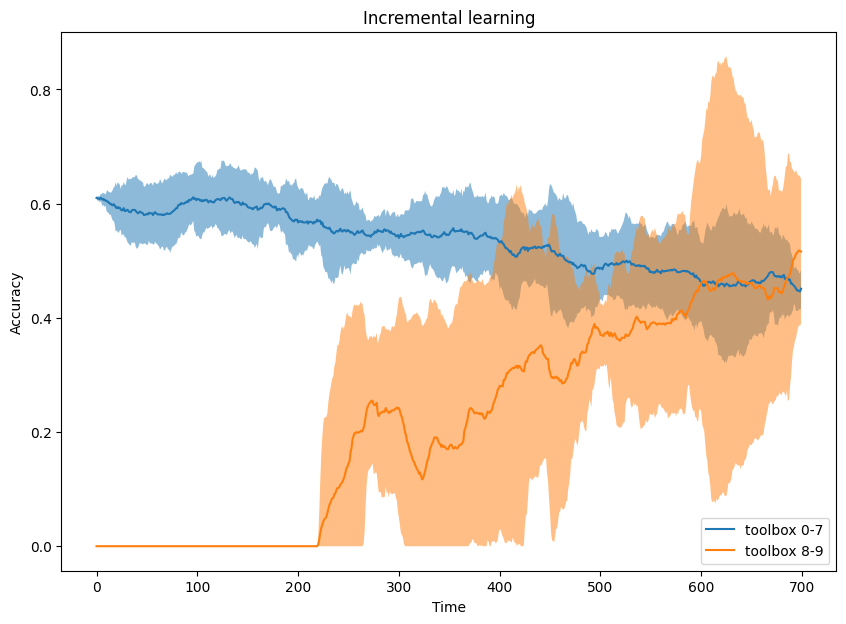

In [154]:
plt.figure(figsize=(10,7))

plt.plot(avg_accuracies_old_tb, label="toolbox 0-7")
std_low = [avg_accuracies_old_tb[i] - 2*std_dev_accuracies_old_tb[i] for i in range(len(avg_accuracies_old_tb))]
std_high = [min(avg_accuracies_old_tb[i] + 2*std_dev_accuracies_old_tb[i], 1) for i in range(len(avg_accuracies_old_tb))]
plt.fill_between([i for i in range(exp_l)], std_low, std_high, alpha=0.5)

plt.plot(avg_accuracies_new_tb, label="toolbox 8-9")
std_low = [max(avg_accuracies_new_tb[i] - 2*std_dev_accuracies_new_tb[i], 0) for i in range(len(avg_accuracies_new_tb))]
std_high = [min(avg_accuracies_new_tb[i] + 2*std_dev_accuracies_new_tb[i], 1) for i in range(len(avg_accuracies_new_tb))]
plt.fill_between([i for i in range(exp_l)], std_low, std_high, alpha=0.5)

plt.title("Incremental learning")
plt.xlabel("Time")
plt.ylabel("Accuracy")
plt.legend(loc=4)